<a href="https://colab.research.google.com/github/HaywhyCoder/imdb-sentiment-analysis/blob/main/imdb-sentiments-analysis-hf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
arunlokanatha_imdb_sentiment_analysis_path = kagglehub.dataset_download('arunlokanatha/imdb-sentiment-analysis')

print('Data source import complete.')


100%|██████████| 432k/432k [00:00<00:00, 625kB/s]

Extracting files...
Data source import complete.


#### Import Libraries

In [ ]:
# ML Libraries
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# NLP
import tensorflow as tf
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from transformers import pipeline
from bs4 import BeautifulSoup
import re

# Suppress warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

#### Load the Dataset

In [ ]:
train = pd.read_csv("/root/.cache/kagglehub/datasets/arunlokanatha/imdb-sentiment-analysis/versions/1/train_min.csv", index_col=0)

In [ ]:
train.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    600 non-null    object
 1   label   600 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 14.1+ KB


In [ ]:
train['label'].value_counts()

,count
label,
0,309
1,291


In [ ]:
train[train['text'].str.contains('<.*?>')]

,text,label
1,"When I put this movie in my DVD player, and sa...",0
4,Im a die hard Dads Army fan and nothing will e...,1
5,A terrible movie as everyone has said. What ma...,0
6,Finally watched this shocking movie last night...,1
7,I caught this film on AZN on cable. It sounded...,0
...,...,...
587,CAUTION: Potential Spoilers Ahead!<br /><br />...,1
590,And a rather Unexpected plot line too-for the ...,1
591,"""TNT Jackson"" isn't completely unwatchable. Bu...",0
593,I have not seen the first film and if it anyth...,0


In [ ]:
# Define a function to clean the data
def clean_text(text):
    """
    A function to remove HTML tags, symbols, and stopwords in a movie review

    Return: Sentence in lowercase with lemmatized words.
    """
    lemmatizer = WordNetLemmatizer()
    text = BeautifulSoup(text, "html.parser").get_text()  # remove html tags
    # text = re.sub(r'[^\w\s]', '', text.lower()) # remove punctuations and symbols
    # stops = set(stopwords.words('english'))
    # # tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stops] #lemmatize and remove stop words
    # tokens = [word for word in text.split() if word not in stops]
    # text = ' '.join(tokens)
    return text

In [ ]:
train['text'] = train['text'].apply(clean_text)

In [ ]:
y = train.pop('label')
X = train

In [ ]:
# Split dataset into train and test sets
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=10)
X_train.head()

,text
133,this show disturbs me. it takes up slots on ni...
303,"Before this made for TV movie began, I had rel..."
339,(Spoilers)Oh sure it's based on Moby Dick. Tot...
458,It used to be my thinking that movies required...
568,"My brother is in love with this show, let's ge..."


In [ ]:
# Load pipeline from huggingface
sentiment_pipeline = pipeline("sentiment-analysis", framework='tf')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
Device set to use 0


In [ ]:
Xtrain_enc = sentiment_pipeline.tokenizer(X_train['text'].tolist(),
                         truncation=True, padding='max_length',
                         add_special_tokens=True, return_tensors='tf') #return numpy object
Xval_enc = sentiment_pipeline.tokenizer(X_val['text'].tolist(),
                         truncation=True, padding='max_length',
                         add_special_tokens=True, return_tensors='tf') #return numpy object
Xtest_enc = sentiment_pipeline.tokenizer(X_test['text'].tolist(),
                         truncation=True, padding='max_length',
                         add_special_tokens=True, return_tensors='tf') #return numpy object

In [ ]:
#preparing datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtrain_enc),
    y_train
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xval_enc),
    y_val
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(Xtest_enc),
    y_test
))

In [ ]:
# Iterate through the train_dataset and val_dataset in batches
print("Training model...")
for batch in train_dataset.batch(32):  # Adjust batch size as needed
    inputs, labels = batch
    outputs = sentiment_pipeline.model(**inputs, labels=labels, training=True)  # Pass inputs as a dictionary
    loss = outputs.loss
    avg_loss = np.average(loss.numpy())
    logits = outputs['logits']
    predicted_labels = np.argmax(logits, axis=1)  # Get predicted labels
    true_labels = labels.numpy()  # Convert labels to numpy

    accuracy = np.sum(predicted_labels == true_labels) / len(true_labels)
    print(f"Accuracy: {accuracy}, loss: {avg_loss}")

print("Evaluating model...")
for batch in val_dataset.batch(32):  # Adjust batch size as needed
    inputs, labels = batch
    outputs = sentiment_pipeline.model(**inputs, labels=labels, training=False)  # Pass inputs as a dictionary
    loss = outputs.loss
    avg_loss = np.average(loss.numpy())
    logits = outputs['logits']
    predicted_labels = np.argmax(logits, axis=1)  # Get predicted labels
    true_labels = labels.numpy()  # Convert labels to numpy

    accuracy = np.sum(predicted_labels == true_labels) / len(true_labels)
    print(f"Accuracy: {accuracy}, loss: {avg_loss}")

Training model...
Accuracy: 0.8125, loss: 0.5912861227989197
Accuracy: 0.90625, loss: 0.23303820192813873
Accuracy: 0.875, loss: 0.3096123933792114
Accuracy: 0.96875, loss: 0.1952255368232727
Accuracy: 0.875, loss: 0.563540518283844
Accuracy: 0.84375, loss: 0.5638042688369751
Accuracy: 0.90625, loss: 0.39489805698394775
Accuracy: 0.875, loss: 0.5346162915229797
Accuracy: 0.875, loss: 0.629936695098877
Accuracy: 0.875, loss: 0.23509550094604492
Accuracy: 0.96875, loss: 0.05074771121144295
Accuracy: 0.875, loss: 0.34119388461112976
Evaluating model...
Accuracy: 0.90625, loss: 0.34193170070648193
Accuracy: 0.875, loss: 0.47101297974586487
Accuracy: 0.90625, loss: 0.2705419063568115


In [ ]:
print("Evaluating model...")
all_predictions = []  # Store predictions for all batches

for batch in test_dataset.batch(32):
    inputs, labels = batch
    outputs = sentiment_pipeline.model(**inputs, labels=labels, training=False)
    logits = outputs['logits']
    predicted_labels = np.argmax(logits, axis=1)  # Get predicted labels
    all_predictions.extend(predicted_labels)  # Add predictions for this batch

accuracy = np.sum(np.array(all_predictions) == np.array(y_test.tolist())) / len(y_test)
print(f"Accuracy on test set: {accuracy}")

Evaluating model...
Accuracy on test set: 0.9


4/4 [==============================] - 5s 590ms/step


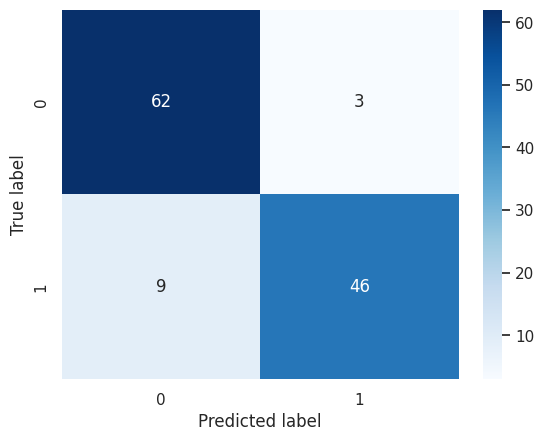

In [ ]:
#Generate predictions for the test dataset
ypred = sentiment_pipeline.model.predict(test_dataset.batch(32))
ypred = np.argmax(ypred.logits, axis=1)

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91        65
           1       0.94      0.84      0.88        55

    accuracy                           0.90       120
   macro avg       0.91      0.90      0.90       120
weighted avg       0.90      0.90      0.90       120



In [ ]:
def predict_sentiment(review):
  inputs = sentiment_pipeline.tokenizer(review,
                                       truncation=True,
                                       padding='max_length',
                                       add_special_tokens=True,
                                       return_tensors='tf')
  y_pred = sentiment_pipeline.model.predict(inputs)
  y_pred = np.argmax(y_pred.logits, axis=1)

  if y_pred == 1:
    print("Sentiment: Positive")
  else:
    print("Sentiment: Negative")

In [ ]:
predict_sentiment("On Swift Horses stumbles a little bit on its way around what feels like an extremely rushed final lap, but this is still a winner")

1/1 [==============================] - 3s 3s/step
Sentiment: Positive


The notebook contains a sentiment analysis task carried out on the IMDB dataset. The TFDistilBertForSequenceClassification model was used for classification. The preprocessing step include removing html tags from the text followed by preprocessing from the pretrained model.
It was observed that the model had a lower performance when cleaning was performed before the texts were passed to the pretrained model, this may be due to the fact that the pretrained pipeline already included text cleaning